In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
import ast
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

### Data

In [71]:
mom_factor = pd.read_excel("../data/momentum_data.xlsx", sheet_name=2, index_col=0)
mom_decile = pd.read_excel(
    "../data/momentum_data.xlsx", sheet_name=3, index_col=0)
mom_size = pd.read_excel("../data/momentum_data.xlsx",
                         sheet_name=4, index_col=0)

In [72]:
factor_ret = pd.read_excel("../data/momentum_data.xlsx", sheet_name=1, index_col=0)
rf = pd.read_excel("../data/momentum_data.xlsx", sheet_name=5, index_col=0)

## Function

In [73]:
def sub_summarize(df, year_list, r, annualize=12):
    col_name = ["mean", "vol", "Sharpe", "skewness"]
    corr_name = [i+"_corr" for i in r.columns]
    res = pd.DataFrame(columns=col_name.extend(corr_name))
    i = 0
    for y in year_list:
        sub1 = df.loc[y[0]: y[1]]
        sub2 = r.loc[y[0]: y[1]]
        res.loc[i, "mean"] = sub1.mean() * annualize
        res.loc[i, "vol"] = sub1.std() * np.sqrt(annualize)
        res.loc[i, "Sharpe"] = res.loc[i, "mean"]/res.loc[i, "vol"]
        res.loc[i, "skewness"] = sub1.skew()

        res.loc[i, corr_name] = np.corrcoef(sub1, sub2, rowvar=False)[0, 1:]
        i += 1
    res.index = pd.Series([repr(y)[1:-1] for y in year_list])
    return res


def summary_stat(df, r, year, annual_factor):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    corr_name = [i+"_corr" for i in r.columns]
    df = df.loc[year[0]: year[1]].copy()
    r = r.loc[year[0]: year[1]].copy()
    result["mean"] = df.mean() * annual_factor
    result["vol"] = df.std() * np.sqrt(annual_factor)
    result["Sharpe"] = result["mean"]/result["vol"]
    result["skewness"] = df.skew()

    result[corr_name] = np.corrcoef(r, df, rowvar=False)[
        r.shape[1]:, :r.shape[1]]
    return result


# 2.Investigating Momentum
## 2.1 Is momentum still profitable?
### (a) Using the data provided, fill in Table 1 with the appropriate stats for $r^{mom:FF}$

In [74]:
mom_size.columns

Index(['SMALL LoPRIOR', 'ME1 PRIOR2', 'SMALL HiPRIOR', 'BIG LoPRIOR',
       'ME2 PRIOR2', 'BIG HiPRIOR'],
      dtype='object')

In [75]:
mom_ff = 1/2*(mom_size["BIG HiPRIOR"]+mom_size["SMALL HiPRIOR"]) - \
    1/2*(mom_size["BIG LoPRIOR"]+mom_size["SMALL LoPRIOR"])

mom_ff = mom_ff.dropna()

year_list = [("1927", "2022"), ("1927", "1993"),("1994", "2008"), ("2009", "2022")]
r = factor_ret[["MKT", "HML"]]
sub_summarize(mom_ff, year_list, r, annualize=12)

,mean,vol,Sharpe,skewness,MKT_corr,HML_corr
"'1927', '2022'",0.0772,0.1626,0.4749,-3.0157,-0.3448,-0.4176
"'1927', '1993'",0.0901,0.1600,0.5630,-3.8093,-0.3625,-0.4949
"'1994', '2008'",0.1043,0.1755,0.5943,-0.5824,-0.2345,-0.1307
"'2009', '2022'",-0.0149,0.1593,-0.0932,-2.8113,-0.3779,-0.3851


### (b) Has momentum changed much over time, as seen through these subsample statistics?

* Momentum's performance has been fairly consistent over the entire sample except that in the past 12 years the mean return has been very poor. 
* In the subperiod 1994-2008, the momentum has the best performance. The sharpe ratio is the highest, and the sknewness is only slightly negative. The correlations to the market and the value factor are the lowest. And this is exactly the period that momentum was published and well-practiced.

### (c) Does this data support AQR’s argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs—would there still be evidence here that momentum is valuable?

* Yes. The persistent performance over time (except for the 2009 crash which causes low mean return in 2009-2022) seems to support the idea that momentum is not just a statistical anomaly. Even in the final subsample, it gives negative correlation to the market and value to the point it is valuable to a mean-variance investor even with a mean return near zero. 

## 2.2 The case is about whether a long-only implementation of momentum is valuable.
### (a) Fill out Table 2 for the data in the period 1994-2022.

In [8]:
mom_u_ff = 1/2*(mom_size["BIG HiPRIOR"] + mom_size["SMALL HiPRIOR"]) - rf["RF"]

In [19]:
year_list = [("1994", "2022")]
sum1 = sub_summarize(mom_ff, year_list, r, annualize=12)
sum2 = sub_summarize(mom_u_ff, year_list, r, annualize=12)
sum = pd.concat([sum1, sum2])
sum.index = ["long-and-short", "long-only"]
sum

,mean,vol,Sharpe,skewness,MKT_corr,HML_corr
long-and-short,0.0473,0.1686,0.2807,-1.4337,-0.3061,-0.2385
long-only,0.1128,0.1789,0.6304,-0.4829,0.9035,-0.1547


### (b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

* Long-only momentum has higher mean return than the long-short momentum, however it has a same volatlity, thushas a higer sharpe ratio.

### (c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia

* No. It has a high correlation with respect to market factor. 

### (d) Show a plot of the cumulative product of $1 + r^{mom·FF}$ and $1 + r^{momU·FF}$ over the 1994-2022 subsample

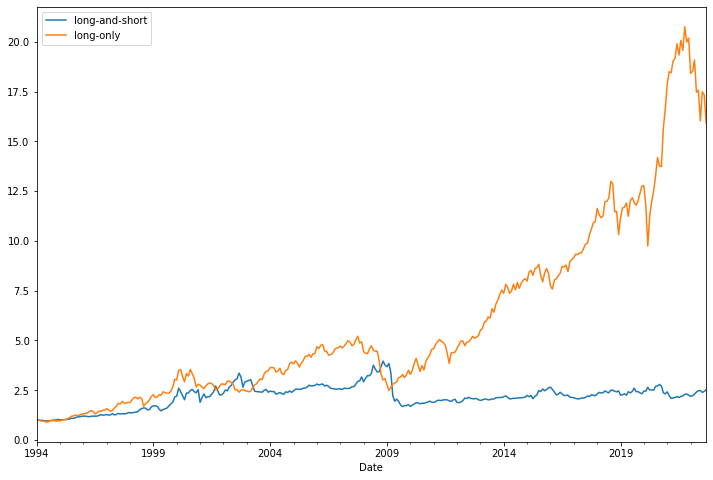

In [10]:
mom_ret = pd.merge(mom_ff.to_frame("long-and-short"),
                   mom_u_ff.to_frame("long-only"), left_index=True, right_index=True)
sub_ret = mom_ret.loc["1994":"2022"]
(sub_ret + 1).cumprod().plot(figsize=(12, 8))

## 2.3 Is momentum just data mining, or is it a robust strategy?
### (a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2022.

In [76]:
mom_d = pd.DataFrame()
mom_d["mom_D1"] = mom_decile["Hi PRIOR"] - mom_decile["Lo PRIOR"]
mom_d["mom_D3"] = 1/3*(mom_decile["PRIOR 8"] + mom_decile["PRIOR 9"] +
              mom_decile["Hi PRIOR"]) - 1/3*(mom_decile["Lo PRIOR"] + mom_decile["PRIOR 2"] + mom_decile["PRIOR 3"])
mom_d["mom_D5"] = mom_decile.iloc[:, 5:].mean(axis=1) - mom_decile.iloc[:, :5].mean(
    axis=1)

In [78]:
sum_d = summary_stat(mom_d, r, ("1994", "2022"), 12)
sum_d

,mean,vol,Sharpe,skewness,MKT_corr,HML_corr
mom_D1,0.0794,0.2980,0.2665,-1.3236,-0.3356,-0.2364
mom_D3,0.0342,0.1926,0.1776,-1.3554,-0.3654,-0.2299
mom_D5,0.0180,0.1340,0.1345,-1.4354,-0.3579,-0.2275


### (b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

* If we build our data from the extreme decile for the "winners" and "losers", we can get higher mean return from the portfolio. The downside is that we would expect higher volatility. This is consistent with what we see here.

### (c) Should AQR’s retail product consider using a 1-decile or 5-decile construction?

* 1-decile. However 1-decile momentum factor has high volatility, it has low correlation to market and value factor. If AQR chooses the 5-decile construction, it means that it will hold all securities on the market, the trading costs from the rebalancing would be huge and the premium would be negative too, but it has a smaller volality and a very diversified portfolio. 

### (d) Compare FF-constructed factor and decile-constructed factor

In [79]:
pd.concat([sum, sum_d])

,mean,vol,Sharpe,skewness,MKT_corr,HML_corr
long-and-short,0.0473,0.1686,0.2807,-1.4337,-0.3061,-0.2385
long-only,0.1128,0.1789,0.6304,-0.4829,0.9035,-0.1547
mom_D1,0.0794,0.2980,0.2665,-1.3236,-0.3356,-0.2364
mom_D3,0.0342,0.1926,0.1776,-1.3554,-0.3654,-0.2299
mom_D5,0.0180,0.1340,0.1345,-1.4354,-0.3579,-0.2275


* The Fama-French construction has a smaller vol, and thus a higher sharpe ratio. Other measures are on the same scale as those of the 3-decile construction. This shows that segment by size actually gives a better performance. 

## 2.4 Does implementing momentum require trading lots of small stocks—thus causing even larger trading costs?
### (a) Fill out Table 4 over the sample 1994-2022.


In [80]:
mom_ff

Date
1927-01-31    0.0036
1927-02-28   -0.0215
1927-03-31    0.0362
1927-04-30    0.0430
1927-05-31    0.0301
               ...  
2022-05-31    0.0248
2022-06-30    0.0080
2022-07-31   -0.0397
2022-08-31    0.0210
2022-09-30    0.0353
Length: 1149, dtype: float64

In [81]:
mom_bs = pd.DataFrame()
mom_bs["mom_ff"] = mom_ff
mom_bs["mom_s"] = mom_size["SMALL HiPRIOR"] - mom_size["SMALL LoPRIOR"]
mom_bs["mom_b"] = mom_size["BIG HiPRIOR"] - mom_size["BIG LoPRIOR"]

In [82]:
sum_bs = summary_stat(mom_bs, r, ("1994", "2022"), 12)
sum_bs

,mean,vol,Sharpe,skewness,MKT_corr,HML_corr
mom_ff,0.0473,0.1686,0.2807,-1.4337,-0.3061,-0.2385
mom_s,0.0627,0.1716,0.3656,-1.7501,-0.3069,-0.1647
mom_b,0.0319,0.1819,0.1755,-0.8576,-0.2780,-0.2869


### (b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

* A momentum strategy in large stocks deliver little bit lower excess return than that in small stocks, and a bigger volatility, thus a lower Shape ratio. 
* However when we consider the liquidity that large stocks have, a momentum strategy in large stocks still delivers excess returns at comparable risk. 

## 2.5 In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

* The AQR retail product is substantially different from what we typically refer to as momentum. Though it has strong expected returns, it is almost all from market premium. This is a feature of being long-only and won't be fixed by modifying the exact constructions decile, sorting by size, etc.